# 音楽音響信号の〇〇gram

音楽音響信号（波形データ）の解析では、だいたい**時間周波数表現（time-frequency representation）** への変換から始まります。音楽音響信号は様々な音要素が混ざり合った複雑な信号であり、波形（waveform）という1次元データから直接音楽的な情報を抽出することは極めて困難です。波形を周波数成分に分解することで、分析したい情報に一歩近づくことができます。

本ページでは、音楽情報処理でよく使われる時間周波数表現（および関連する音響特徴量）とその特徴を紹介します。

## STFT Spectrogram

**STFT（Short Time Fourier Transform、短時間フーリエ変換）スペクトログラム**は、波形データから一定間隔に切り取った波形フレームをフーリエ変換し、時間軸上に並べることで作られます。
0Hz~ナイキスト周波数までの範囲を均等に分割した、各周波数域成分の時間変化を知ることができます。

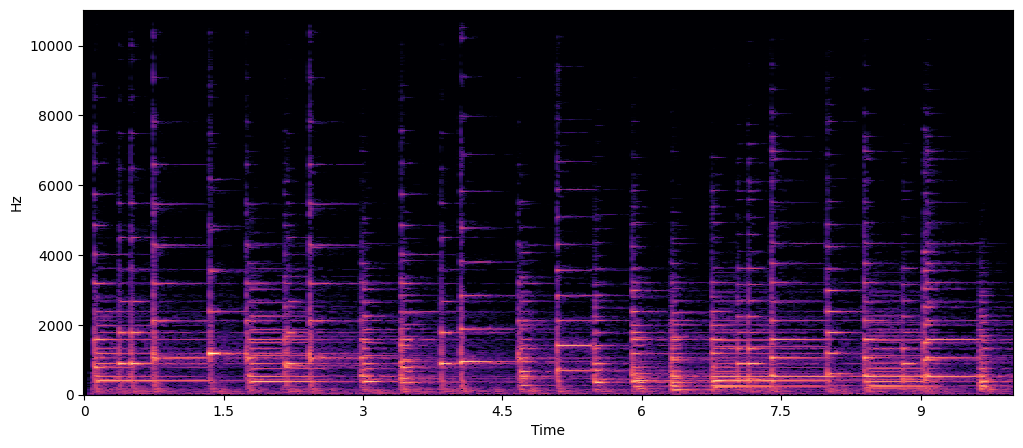

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

waveform, sample_rate = librosa.load('assets/example1.ogg', sr=22050)
waveform = waveform[:sample_rate*10]   # 最初の10秒
stft_spectrogram = librosa.stft(waveform)

display(Audio(waveform, rate=sample_rate))

plt.figure(figsize=(12, 5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrogram), ref=np.max), sr=sample_rate, x_axis='time', y_axis='linear')

音楽情報処理ersは、特にSTFTスペクトログラムの以下の性質に注意を払っています。


* **窓幅の決め方：** 窓幅が長いほど、周波数分解能が上がり、時間分解能が下がるので、タスクにとって丁度いい窓幅を見つける必要があります。
次に述べるように、STFTスペクトログラムは低周波数域の分解能不足が問題になりがちなので、「最低音域をちょうど区別できるくらい」の窓幅が目安の一つです。

* **周波数域と人間の知覚的尺度のギャップ：** STFTスペクトログラムの周波数軸は線形になっており、隣り合う次元の中心周波数は一定間隔になっています。
対して人間が音高を知覚する尺度は対数尺度に近いため、「聴覚的に音高が等間隔な音が、STFTスペクトログラム上では等間隔にならない」というギャップが生じます。

* **周波数によってに異なる分解能：** FFTは全ての周波数を同じ窓幅で解析しているので、低周波数（＝長い波長）域では分解能が不足し、逆に高周波数（＝短い波長）域では分解能が過剰になります。上の図を見ても、低域は過密でぼやけており、高域ほど線が細く感覚も開いていく傾向が見て取れると思います。
音楽信号内のどの音域も平等に扱いたい場合、音の高低によって分解能が異なるのは不便です。

STFTスペクトログラムは他の特徴量を求める第一歩にもなる、最も基本的な時間周波数表現の一つですが、
次元数が大きめであり、上記の性質もあって直接活用される場面は多くありません。
STFTは（隣接フレームがオーバーラップしていれば）可逆な変換なので、スペクトログラムに何かしらの処理を加えたあと、再び波形に戻したい時に使われることがあります（e.g. 音源分離）[^demucs21] [^kong21]。

[^demucs21]: Alexandre D\'efossez, Hybrid Spectrogram and Waveform Source Separation, in Proceedings of the ISMIR 2021 Workshop on Music Source Separation, 2021. URL: https://arxiv.org/abs/2111.03600

[^kong21]: QiuQiang Kong et al., Decoupling Magnitude and Phase Estimation with Deep ResUNet for Music Source Separation, in Proceedings of ISMIR, 2021. URL: https://archives.ismir.net/ismir2021/paper/000042.pdf

## Mel Spectrogram

STFTスペクトログラムの周波数軸を、「メル尺度」という音高の知覚的尺度に変換したスペクトログラムです。
STFT振幅スペクトログラムを、メルフィルタバンクを表す行列と乗算すると、メルスペクトログラムになります。

Text(0.5, 1.0, 'Mel spectrogram')

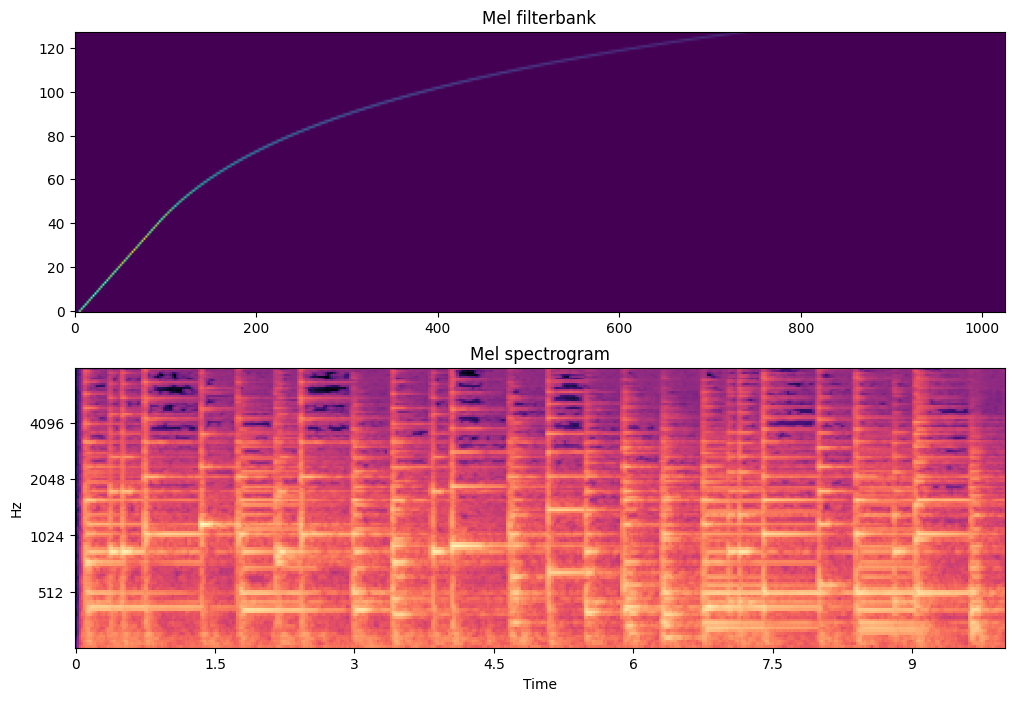

In [20]:
mel_filterbank = librosa.filters.mel(
    sr=sample_rate, 
    fmin=30, 
    fmax=8000, 
    n_fft=2048, 
    n_mels=128,
)
mel_spectrogram = mel_filterbank @ np.abs(stft_spectrogram) # メルスペクトログラム＝メルフィルタバンクとSTFTスペクトログラムの積

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.imshow(mel_filterbank, aspect='auto', origin='lower', cmap='viridis')
plt.title('Mel filterbank')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel', fmin=30, fmax=8000)
plt.title('Mel spectrogram')

STFTにあった高域のスカスカ感が圧縮されていますね。

`librosa`や`torchaudio`などのライブラリでは、`slaney`と`htk`という２つのメル尺度が用意されています。
`slaney`は`MATLAB Auditory Toolbox`というMATLABライブラリに由来する尺度で、1kHz以下は線形、1kHz以上は対数スケールに変換しています。

$
mel_{slaney}=
\begin{cases}
\frac{f-f_{min}}{66.67} & (f \leq 1000)\\
1000 + \frac{\log(f/1000)}{0.069} & (f \gt 1000)
\end{cases}
$

一方`htk`は、隠れマルコフモデルの実装に使うライブラリ`Hidden Markov Model Toolkit (HTK)`に由来する尺度で、こちらは全部対数スケールです。

$mel_{htk} = 2595.0 * \log_{10}(1.0 + f / 700.0)$

`librosa`は`slaney`、`torchaudio`は`htk`をデフォルトに設定しており、若干扱いに注意が要ります。


Deep learning eraの研究では、入力データの選択に迷ったら「**とりあえずメルスぺで**」とすることが多いです。

## CQT Spectrogram

STFTスペクトログラムには「周波数によって分解能が異なる」という問題がありました。各周波数の分解能を一定にさせるには、周波数ごとに異なる窓幅を使う必要があります。
CQT（Constant-Q Transform）は、「**窓幅と波長の比率が一定になる**」ような窓幅を使います。

`librosa`にはCQTの周波数と窓幅を計算するユーティリティ関数があるので、88鍵ピアノの周波数の窓幅を見てみます。

In [21]:
cqt_frequencies = librosa.cqt_frequencies(n_bins=88, fmin=librosa.note_to_hz('A0'))                     # 88鍵のピアノの周波数
cqt_wavelengths = sample_rate / cqt_frequencies                                                         # 波長
cqt_lengths, _ =librosa.filters.wavelet_lengths(freqs=cqt_frequencies, sr=sample_rate, filter_scale=2)  # 窓幅
print(cqt_lengths)

[27793.56844096 26233.63530919 24761.2544966  23371.51206911
 22059.76989057 20821.65014338 19653.02071798 18549.9814223
 17508.85096523 16526.15467065 15598.61288103 14723.13001187
 13896.78422048 13116.81765459 12380.6272483  11685.75603456
 11029.88494528 10410.82507169  9826.51035899  9274.99071115
  8754.42548262  8263.07733533  7799.30644052  7361.56500594
  6948.39211024  6558.4088273   6190.31362415  5842.87801728
  5514.94247264  5205.41253584  4913.25517949  4637.49535557
  4377.21274131  4131.53866766  3899.65322026  3680.78250297
  3474.19605512  3279.20441365  3095.15681207  2921.43900864
  2757.47123632  2602.70626792  2456.62758975  2318.74767779
  2188.60637065  2065.76933383  1949.82661013  1840.39125148
  1737.09802756  1639.60220682  1547.57840604  1460.71950432
  1378.73561816  1301.35313396  1228.31379487  1159.37383889
  1094.30318533  1032.88466692   974.91330506   920.19562574
   868.54901378   819.80110341   773.78920302   730.35975216
   689.36780908   650.676

このように、波長が長い低周波数域の窓幅はとんでもなく長くなります。

CQTを使えば、各周波数域のエネルギーを同じ尺度で測られたスペクトログラムを得ることができます。

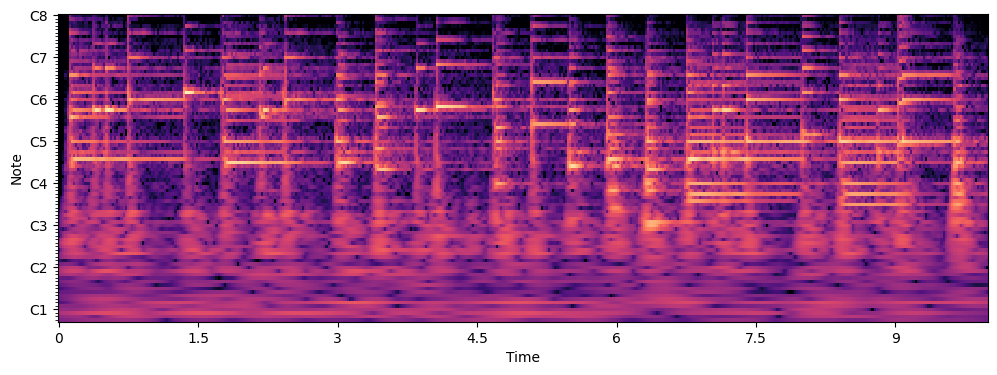

In [22]:
cqt_spectrogram = librosa.cqt(waveform, sr=sample_rate, fmin=librosa.note_to_hz('A0'), n_bins=88, bins_per_octave=12, filter_scale=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(cqt_spectrogram), ref=np.max), sr=sample_rate, x_axis='time', y_axis='cqt_note', fmin=librosa.note_to_hz('A0'), fmax=librosa.note_to_hz('C8'))

周波数分解能が一定になる代償は時間分解能が変動することです。低域になるにつれて窓幅が急激に長くなるため、特に下の部分は横方向に著しくぼやけます。

自動採譜など音高情報に注目するタスクでは、「**CQTのほうが音楽の音高情報の表現に適している**」と考え、メルスペクトログラムではなくCQTが入力に使われることがあります。

また、「音楽の大規模基盤モデル」MERTは、自己教師あり学習の際に潜在特徴からのCQTスペクトログラム再構成品質を損失関数に加えることで、潜在特徴に「より音楽的な」表現を獲得させるテクニックを提案しています[^mert24]。

実際本当にメルスぺよりも「音楽に適している」のかは議論の余地がありますが、そういうイメージを持たれているということです。

[^mert24]: Yizhi Li et al. MERT: Acoustic Music Understanding Model with Large-Scale Self-supervised Training, in The Twelfth International Conference on Learning Representations (ICLR), 2024. URL: https://openreview.net/forum?id=w3YZ9MSlBu

## Chromagram

スペクトログラムの広い周波数域を、オクターブを考慮しない12半音ぶんの音高（クロマティックスケール）に縮約した特徴量です。オクターブを考慮しない音高は「ピッチクラス」と呼ばれ、Chromagramは「Pitch Class Profile (PCP)」と呼ばれることもあります。

音楽コード推定やキー推定、カバーソング識別など、どちらかというと相対的な音高情報に注目するようなタスクで使われています。

スペクトログラムの各周波数域を対応するピッチクラスの次元に足し込むことで計算されるので、メルスペクトログラムと同様、スペクトログラムにフィルタバンクを掛けることで計算できます。

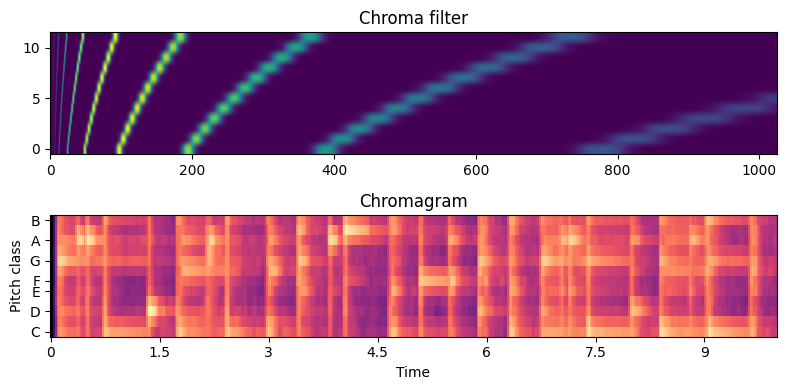

In [23]:
chroma_filter = librosa.filters.chroma(sr=sample_rate, n_fft=2048)  # フィルタバンク
chromagram = chroma_filter @ np.abs(stft_spectrogram)               # クロマグラム＝クロマフィルタバンクとSTFTスペクトログラムの積

plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plt.imshow(chroma_filter, aspect='auto', origin='lower', cmap='viridis')
plt.title('Chroma filter')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(chromagram), sr=sample_rate, x_axis='time', y_axis='chroma')
plt.title('Chromagram')
plt.tight_layout()

周波数分解能が不均等なため、STFTスペクトログラムからクロマグラムを作ると、低音の成分がより強調される傾向があります。

もちろんCQTスペクトログラムから作ることもできます。周波数分解能が均等なため、低音以外の音高成分もクロマグラムで強調され、より和声分析に向いているように見えます。
音楽の音高信号を分析する際はこっちが好まれることが多いです。

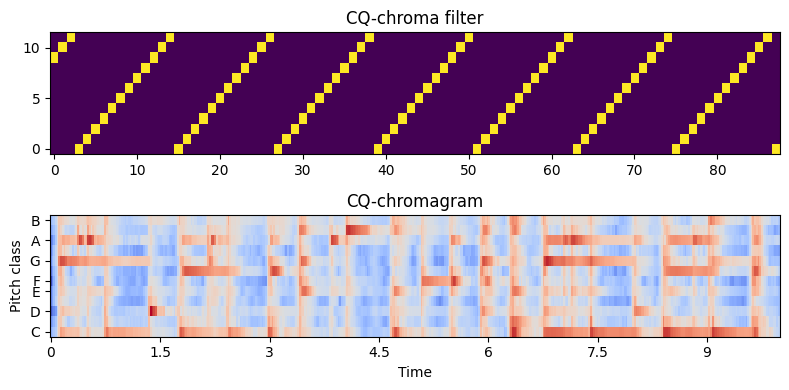

In [24]:
cq_chroma_filter = librosa.filters.cq_to_chroma(n_input=88, fmin=librosa.note_to_hz('A0'))  # CQTスペクトログラム用のフィルタバンク
cq_chromagram = cq_chroma_filter @ np.abs(cqt_spectrogram)                                  

plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plt.imshow(cq_chroma_filter, aspect='auto', origin='lower', cmap='viridis')
plt.title('CQ-chroma filter')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(cq_chromagram), sr=sample_rate, x_axis='time', y_axis='chroma')
plt.title('CQ-chromagram')
plt.tight_layout()

STFTやCQTスペクトログラムから計算したクロマグラムは、倍音成分の影響が含まれてしまします。より「キレイな」クロマグラムを作るため、もういっそDNNにクロマグラムを作ってもらおう、という提案もされています[^KW16] [^WP21]。実質的に、簡易な和音解析あるいは音高認識を行っているようなものです。

[^KW16]: Filip Korzeniowski and Gerhard Widmer. Feature learning for chord recognition: the deep chroma extractor. In Michael I. Mandel, Johanna Devaney, Douglas Turnbull, and George Tzanetakis, editors, Proceedings of the 17th International Society for Music Information Retrieval Conference, ISMIR 2016, New York City, United States, August 7-11, 2016, 37–43. 2016. URL: https://wp.nyu.edu/ismir2016/wp-content/uploads/sites/2294/2016/07/178\_Paper.pdf.

[^WP21]: Christof Weiss and Geoffroy Peeters. Training deep pitch-class representations with a multi-label CTC loss. In Jin Ha Lee, Alexander Lerch, Zhiyao Duan, Juhan Nam, Preeti Rao, Peter van Kranenburg, and Ajay Srinivasamurthy, editors, Proceedings of the 22nd International Society for Music Information Retrieval Conference, ISMIR 2021, Online, November 7-12, 2021, 754–761. 2021. URL: https://archives.ismir.net/ismir2021/paper/000094.pdf.